# Predicción de Fuga de Clientes en el Sector Bancario (Bank Churn Prediction)

### 1. Contexto del Negocio
En la industria bancaria actual, la competencia es feroz y los costos de adquisición de nuevos clientes son significativamente más altos que los costos de retención. La fuga de clientes (conocida como **Churn**) representa un problema crítico que impacta directamente en los ingresos y la rentabilidad de la institución.

Identificar a tiempo qué clientes tienen una alta probabilidad de abandonar el banco permite a los equipos de marketing y fidelización tomar medidas proactivas (como ofrecer mejores tasas, productos personalizados o atención preferencial) para evitar dicha pérdida.

### 2. Objetivo del Proyecto
El objetivo principal de este análisis es desarrollar un modelo de Machine Learning robusto capaz de predecir la probabilidad de fuga de un cliente bancario basándose en su perfil demográfico, comportamiento financiero y relación con la entidad.

### 3. Metodología
Para abordar este problema de clasificación supervisada, se seguirá el siguiente flujo de trabajo:
1.  **Análisis Exploratorio de Datos (EDA):** Entender la distribución de las variables y detectar patrones visuales de fuga.
2.  **Preprocesamiento:** Codificación de variables categóricas y manejo del desbalanceo de clases (el dataset presenta solo un ~20% de casos de fuga).
3.  **Modelado:** Implementación del algoritmo **XGBoost** (Extreme Gradient Boosting), optimizando sus hiperparámetros mediante `GridSearchCV`.
4.  **Estrategias de Balanceo:** Comparación de técnicas de *Random Undersampling* vs. *Random Oversampling* (y opcionalmente SMOTE) para maximizar la detección de fugas (Recall).
5.  **Interpretabilidad:** Uso de **SHAP Values** para explicar qué factores influyen más en la decisión de abandono del cliente.

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
ruta = "/content/drive/MyDrive/PROYECTOS PERSONALES/Bank Customer Churn Prediction.csv"

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Análisis preliminar del DataFrame

### Descripción del Dataset

El conjunto de datos contiene información histórica sobre los clientes del banco. A continuación, se detalla el significado de cada variable:

| Variable | Descripción | Tipo de Dato |
| :--- | :--- | :--- |
| **customer_id** | Identificador único del cliente (se elimina para el modelado). | Numérico |
| **credit_score** | Puntaje crediticio del cliente. Indica su solvencia financiera. | Numérico |
| **country** | País de residencia del cliente (France, Spain, Germany). | Categórico |
| **gender** | Género del cliente (Male, Female). | Categórico |
| **age** | Edad del cliente en años. | Numérico |
| **tenure** | Antigüedad o número de años que el cliente ha estado vinculado al banco. | Numérico |
| **balance** | Saldo disponible en la cuenta bancaria del cliente. | Numérico |
| **products_number** | Número de productos bancarios que el cliente tiene contratados (ej. cuentas, seguros, préstamos). | Numérico |
| **credit_card** | Indica si el cliente posee una tarjeta de crédito (1 = Sí, 0 = No). | Binario |
| **active_member** | Indica si el cliente es un miembro activo, basado en su transaccionalidad reciente (1 = Sí, 0 = No). | Binario |
| **estimated_salary** | Salario anual estimado del cliente. | Numérico |
| **churn** | **Variable Objetivo.** Indica si el cliente abandonó el banco (1 = Sí/Fuga) o permaneció (0 = No). | Binario |

In [93]:
data = pd.read_csv(ruta)
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [95]:
data.isna().sum()

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


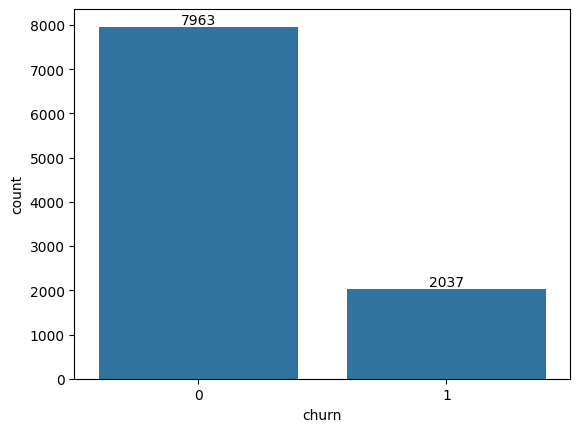

In [96]:
plt.figure()
ax = sns.countplot(x=data["churn"])
for container in ax.containers:
  ax.bar_label(container)
plt.show()

In [97]:
data['churn'].mean()

np.float64(0.2037)

## Se evidencia existencia de un fuerte desbalanceo. En donde solo el 20% de los datos pertenecen a la clase de fuga

# Modelado

In [98]:
data = data.copy()
data.drop(columns="customer_id",axis=1,inplace=True)

In [99]:
data = pd.get_dummies(data, columns=['gender'])

In [100]:
X_vars = ['credit_score','gender_Male','gender_Female','age','tenure','balance','products_number','credit_card','active_member','estimated_salary']
y_vars = "churn"

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(data[X_vars],data[y_vars],test_size=0.25,random_state=42)

## Modelo balanceado por undersampling

In [103]:
from imblearn.under_sampling import RandomUnderSampler

In [104]:
rus = RandomUnderSampler(random_state=42)
X_sub, y_sub = rus.fit_resample(X_train, y_train)

### XGBoost undersampled

Como modelo de prueba utilizaremos el XGBoost, además utilizaremos GridSearchCV para optimizar los hiperparámetros

In [105]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_curve,auc
import shap

In [106]:
modelo_xgb_under = xgb.XGBClassifier()

In [107]:
param_grid = {"max_depth":[1,3,5,7,9],"n_estimators":[100,200,300,400,500],"learning_rate":[0.01,0.1,0.2,0.3]}

In [108]:
grid_sub = GridSearchCV(estimator=modelo_xgb_under,
                        param_grid=param_grid,
                        cv=5)

In [109]:
grid_sub.fit(X_sub,y_sub)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [110]:
y_pred = grid_sub.best_estimator_.predict(X_test)

In [111]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      2003
           1       0.47      0.73      0.57       497

    accuracy                           0.78      2500
   macro avg       0.70      0.76      0.72      2500
weighted avg       0.83      0.78      0.80      2500



#### Feature Importance

<Figure size 1500x800 with 0 Axes>

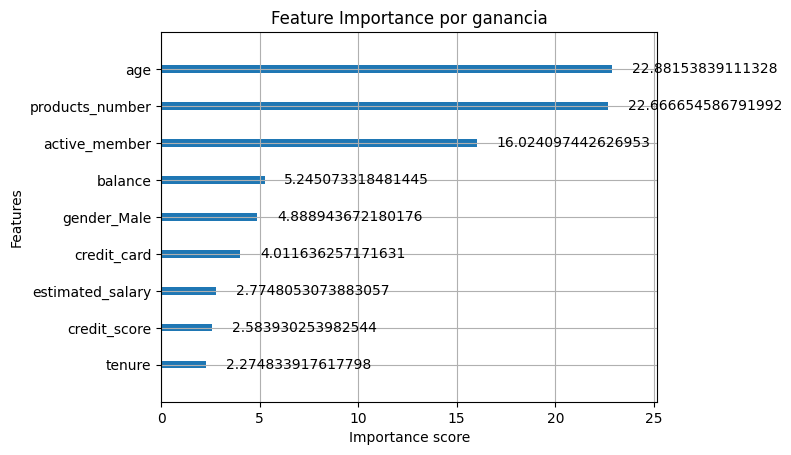

In [127]:
best_model = grid_sub.best_estimator_
plt.figure(figsize=(15,8))
plot_importance(best_model,importance_type="gain",max_num_features=10)
plt.title("Feature Importance por ganancia")
plt.show()

#### Gráfico de Shap

In [113]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

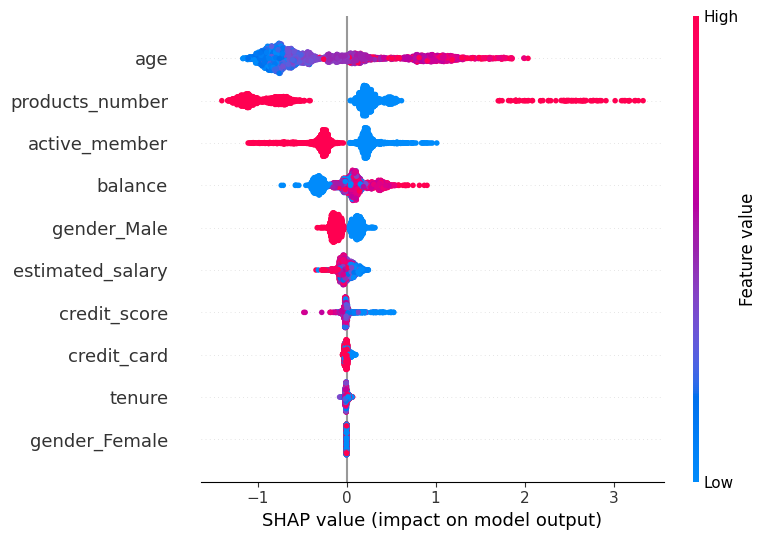

In [114]:
plt.figure()
shap.summary_plot(shap_values, X_test,feature_names=X_vars)
plt.show()

### Evaluación del Modelo XGBoost (Random Undersampling)

Al aplicar *Random Undersampling* para equilibrar las clases, observamos un comportamiento característico de priorización de la clase minoritaria:

* **Prioridad en el Recall (Sensibilidad):** El modelo ha logrado un **Recall del 73%** para la clase de interés (Churn).
    * **Interpretación:** Esto indica que el algoritmo es capaz de identificar correctamente a casi 3 de cada 4 clientes que están en riesgo de abandonar el banco. En un contexto de fuga de clientes, capturar la mayor cantidad de casos reales es la prioridad número uno.
* **Costo en Precisión:** Como contrapartida, la Precisión de la clase positiva se sitúa en el **47%**.
    * **Interpretación de Negocio:** Esto significa que el modelo es "sobre-protector": genera un número considerable de falsas alarmas (Falsos Positivos). Sin embargo, esto es preferible a ignorar una fuga real, ya que el costo de una campaña de retención es menor que la pérdida de un cliente.

## Modelo balanceado por oversampling

In [115]:
from imblearn.over_sampling import RandomOverSampler

In [116]:
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train,y_train)

### XGBoost Oversampled

In [117]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_curve,auc
import shap

In [118]:
modelo_xgb_over = XGBClassifier()

In [119]:
param_grid = {"max_depth":[1,3,5,7,9],"n_estimators":[100,200,300,400,500],"learning_rate":[0.01,0.1,0.2,0.3]}

In [120]:
grid_over = GridSearchCV(estimator=modelo_xgb_over,
                        param_grid=param_grid,
                        cv=5)

In [121]:
grid_over.fit(X_over,y_over)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [122]:
y_pred = grid_over.best_estimator_.predict(X_test)

In [123]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2003
           1       0.61      0.50      0.55       497

    accuracy                           0.84      2500
   macro avg       0.75      0.71      0.73      2500
weighted avg       0.83      0.84      0.83      2500



#### Feature importance

<Figure size 1500x800 with 0 Axes>

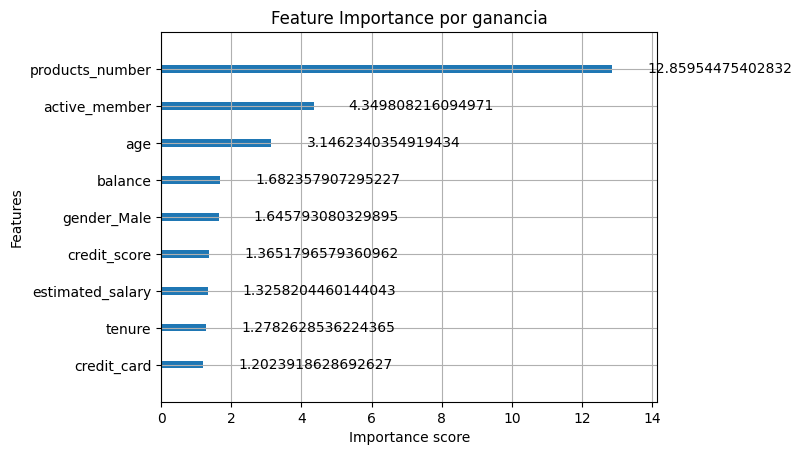

In [124]:
best_model = grid_over.best_estimator_
plt.figure(figsize=(15,8))
plot_importance(best_model,importance_type="gain",max_num_features=10)
plt.title("Feature Importance por ganancia")
plt.show()

#### Gráfico de Shap

In [125]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

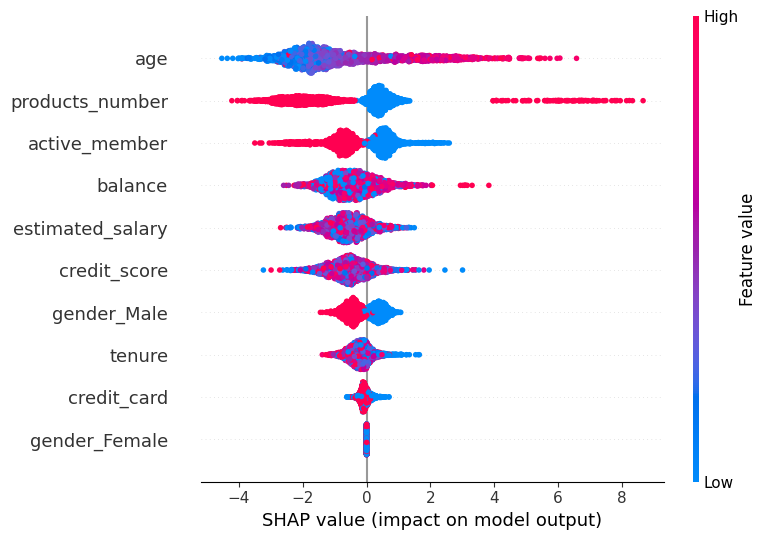

In [126]:
plt.figure()
shap.summary_plot(shap_values, X_test,feature_names=X_vars)
plt.show()

### Evaluación del Modelo XGBoost (Random Oversampling)

Al aplicar *Random Oversampling*, observamos un fenómeno interesante conocido como la "Paradoja de la Exactitud":

* **Mejora General:** La exactitud global (Accuracy) subió al **84%** y la Precisión de la clase 'Churn' mejoró al **61%**. Esto indica que el modelo es más "seguro" cuando lanza una alerta; se equivoca menos con los clientes fieles.
* **Deterioro Crítico del Recall:** Sin embargo, el Recall de la clase 'Churn' cayó drásticamente al **50%**.
    * **Interpretación de Negocio:** Este modelo falla en detectar a la mitad de los clientes que abandonan el banco.
    * **Veredicto:** Aunque genera menos "ruido" (menos falsos positivos), su incapacidad para detectar el 50% de las fugas lo hace **menos rentable** que el modelo de Undersampling para una estrategia agresiva de retención.

| Métrica (Clase 1 - Fuga) | Undersampling | Oversampling | ¿Quién gana? |
| :--- | :---: | :---: | :--- |
| **Recall (Sensibilidad)** | **0.73** | 0.50 | 🏆 Undersampling (Crucial para Churn) |
| **Precision** | 0.47 | **0.61** | 🏆 Oversampling |
| **F1-Score** | **0.57** | 0.55 | 🤝 Empate técnico |
| **Accuracy Global** | 0.78 | **0.84** | ⚠️ Oversampling (Engañoso) |

# Conclusiones Generales y Selección del Modelo

Tras comparar las estrategias de balanceo de datos mediante *Random Undersampling* y *Random Oversampling*, se llega a las siguientes conclusiones de negocio y técnicas:

### 1. Comparativa entre Precisión y Recall
Se evidenció un claro intercambio (*trade-off*) entre las métricas al variar la técnica de muestreo:
* **Undersampling:** Maximiza la detección de fugas (**Recall: 73%**) pero a costa de generar más falsas alarmas (**Precision: 47%**).
* **Oversampling:** Reduce las falsas alarmas (**Precision: 61%**) y mejora la exactitud global (**Accuracy: 84%**), pero falla en detectar a la mitad de los clientes en riesgo (**Recall: 50%**).

### 2. Selección del Modelo Ganador
Para el caso de uso específico de **Banking Churn**, se selecciona el modelo entrenado con **Undersampling** como el más apto para producción.

**Justificación Económica:**
* **Costo de Falso Negativo (Perder un cliente):** Alto (Pérdida de LTV, depósitos, productos cruzados).
* **Costo de Falso Positivo (Campaña innecesaria):** Bajo (Costo de contacto, email, pequeño incentivo).

Dado que es financieramente más crítico retener a un cliente que se va, que evitar molestar a uno que se queda, el modelo de Undersampling, con su capacidad superior para detectar el 73% de las fugas, ofrece un mayor retorno de inversión (ROI) potencial para el banco a pesar de su menor exactitud global.